<a href="https://colab.research.google.com/github/dh610/Advanced-AI/blob/main/Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice2: Data Augmentation 구현하기


## 1. 문제 설명
1. Mixup 유무에 따른 모델 검증 결과 비교하기.
2. Cutmix 유무에 따른 모델 검증 결과 비교하기.
3. 조건: 주어진 노트북의 다른 hyperparameter는 변경하지 말고 data augmentation만 변경할 것. 실습 과제 제출시에 사용한 모델과 모든 로그가 담겨 있는 노트북 제출.

## 2. 목차
1. 필요한 패키지 불러오기 및 parameter 구성하기
2. CIFAR10 데이터 가져오기
3. Trainloader 이미지 살펴보기
4. ResNet 모델 정의
5. 모델 학습 및 검증 (이 섹션에 mixup, cutmix 적용하기)

## 3. 참고자료
1. (ResNet) Deep Residual Learning for Image Recognition, CVPR, 2016 [[ArXiv](https://arxiv.org/pdf/1512.03385)]
2. (*) (mixup) mixup: Beyond Empirical Risk Minimization, ICLR, 2017 [[ArXiv](https://arxiv.org/pdf/1710.09412)]
3. (**) (cutmix) CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features, ICCV, 2019 [[ArXiv](https://arxiv.org/pdf/1905.04899)]


## 1. 필요한 패키지 불러오기 및 Parameter 구성하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 256,
          'worker'      : 2,
          'epochs'      : 50,
          'momentum'    : 0.9,
          'wd_decay'    : 0.0005,
          'Adam_lr'     : 0.0005,
          }

cuda


## 2. CIFAR10 데이터 가져오기
CIFAR10의 정규화를 위해 직접 CIFAR10 데이터의 평균과 표준편차를 구해서 Train/Test 데이터셋에 정규화를 적용한다.

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000


In [ ]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in trainset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in trainset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

In [ ]:
print("CIFAR10_MEAN:",train_meanR, train_meanG, train_meanB) # Cifar10_stats -> mean
print("CIFAR10_STD:",train_stdR, train_stdG, train_stdB) # Cifar10_stats-> std

CIFAR10_MEAN: 0.49139965 0.48215845 0.4465309
CIFAR10_STD: 0.20220213 0.19931543 0.20086348


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomCrop(128, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# apply transform
trainset.transform = train_transforms
testset.transform = test_transforms

# Data Loader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. trainloader 이미지 살펴보기

CIFAR10데이터 가져오기에서 만든 trainloader에 이미지가 어떻게 저장되어있는지 이미지와 라벨을 같이 확인해본다.

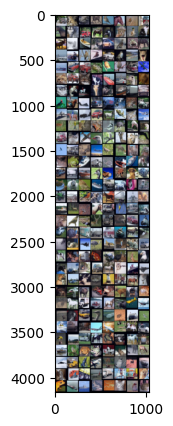

1: frog  	2: frog  	3: frog  	4: horse  	5: bird  	6: horse  	7: bird  	8: truck
9: horse  	10: horse  	11: truck  	12: horse  	13: bird  	14: cat  	15: bird  	16: cat
17: deer  	18: airplane	19: ship  	20: deer  	21: automobile	22: bird  	23: frog  	24: horse
25: airplane	26: truck  	27: bird  	28: bird  	29: automobile	30: frog  	31: ship  	32: cat
33: ship  	34: automobile	35: truck  	36: frog  	37: bird  	38: bird  	39: truck  	40: airplane
41: cat  	42: automobile	43: cat  	44: cat  	45: ship  	46: ship  	47: bird  	48: cat
49: ship  	50: cat  	51: horse  	52: bird  	53: deer  	54: ship  	55: truck  	56: automobile
57: bird  	58: horse  	59: airplane	60: automobile	61: truck  	62: deer  	63: frog  	64: truck
65: airplane	66: horse  	67: airplane	68: automobile	69: horse  	70: airplane	71: cat  	72: airplane
73: deer  	74: bird  	75: frog  	76: frog  	77: bird  	78: bird  	79: bird  	80: cat
81: truck  	82: cat  	83: airplane	84: bird  	85: bird  	86: deer  	87: deer  	88: frog
89:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2, 0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

## 4. 모델 정의

In [ ]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size = 1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride = stride, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

## 5. 모델 학습 및 검증

In [ ]:
def mixup(x, y, num_classes=10):
    assert False, "you should implement mixup first"

def cutmix(x, y, num_classes=10):
    assert False, "you should implement cutmix first"

for augmentation in ['none', 'mixup', 'cutmix']:
    model = ResNet18().to(device)
    model = model.to(memory_format=torch.channels_last)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(params=model.parameters(), lr = config['Adam_lr'], weight_decay=config['wd_decay'])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, config['Adam_lr'], total_steps=config['epochs'] * len(trainloader))

    for epoch in range(config['epochs']):  # loop over the dataset multiple times

        running_loss = 0.0
        start_time = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs.to(memory_format=torch.channels_last)

            if augmentation == 'none':
                pass
            elif augmentation == 'mixup':
                inputs, labels = mixup(inputs, labels)
            elif augmentation == 'cutmix':
                inputs, labels = cutmix(inputs, labels)
            else:
                raise Exception(f'{augmentation} is not supported yet')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.cuda.amp.autocast(True):
                output = model(inputs)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

            #Time
            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')

        print('Epoch: {}/{}, train_loss: {:.4f}, time:{}m {}s'.format(epoch + 1, config['epochs'], running_loss / len(trainset), time_taken[0], time_taken[1][:2]))

    print(f'Finished Training of ResNet18 with {augmentation} augmentation')

    #Testing Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the ResNet18 with {augmentation} on the 10000 test images: {100 * correct / total:.2f}%')

Epoch: 1/50, train_loss: 0.0072, time:0m 45s
Epoch: 2/50, train_loss: 0.0056, time:0m 40s
Epoch: 3/50, train_loss: 0.0049, time:0m 40s
Epoch: 4/50, train_loss: 0.0043, time:0m 40s
Epoch: 5/50, train_loss: 0.0038, time:0m 40s
Epoch: 6/50, train_loss: 0.0035, time:0m 40s
Epoch: 7/50, train_loss: 0.0031, time:0m 40s
Epoch: 8/50, train_loss: 0.0028, time:0m 41s
Epoch: 9/50, train_loss: 0.0025, time:0m 42s
Epoch: 10/50, train_loss: 0.0023, time:0m 40s
Epoch: 11/50, train_loss: 0.0021, time:0m 41s
Epoch: 12/50, train_loss: 0.0020, time:0m 43s
Epoch: 13/50, train_loss: 0.0019, time:0m 40s
Epoch: 14/50, train_loss: 0.0018, time:0m 40s
Epoch: 15/50, train_loss: 0.0017, time:0m 40s
Epoch: 16/50, train_loss: 0.0015, time:0m 42s
Epoch: 17/50, train_loss: 0.0014, time:0m 40s
Epoch: 18/50, train_loss: 0.0014, time:0m 39s
Epoch: 19/50, train_loss: 0.0013, time:0m 39s
Epoch: 20/50, train_loss: 0.0012, time:0m 39s
Epoch: 21/50, train_loss: 0.0011, time:0m 40s
Epoch: 22/50, train_loss: 0.0011, time:0m 4

AssertionError: you should implement mixup first